In [2]:
import geopandas as gpd
import requests, pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Establishing Shelby County as a target zone to work with tracts

tracts = gpd.read_file(r"C:\Users\zmrplaza\Downloads\tl_2024_47_tract")
tracts = tracts[tracts["COUNTYFP"] == "157"]

In [10]:
#Using ACS 5-year via Census API to get the information for the last year available 2022
#B01001_003E Male under 5 years
#B01001_027E Female under 5 years

CENSUS_KEY = "6fe2432068a36984d81b8c033db863b7f24983ee"
url = "https://api.census.gov/data/2022/acs/acs5"
params = {
    "get": "NAME,B01001_003E,B01001_027E,B01003_001E",
    "for": "tract:*",
    "in": "state:47 county:157",
    "key": CENSUS_KEY
}
r = requests.get(url, params=params)
data = r.json()
df_pop = pd.DataFrame(data[1:], columns=data[0])
df_pop["pop_under5"] = df_pop["B01001_003E"].astype(int) + df_pop["B01001_027E"].astype(int)
df_pop["GEOID"] = df_pop.state + df_pop.county + df_pop.tract
df_pop["total_population"] = df_pop["B01003_001E"].astype(int)


#Merging the information to get the total population under 5 y

gdf_u5 = tracts.merge(df_pop[["GEOID", "pop_under5", "total_population"]], on="GEOID")

gdf_u5["pct_u5"] = gdf_u5["pop_under5"] / gdf_u5["total_population"]

gdf_u5["pct_u5"] = gdf_u5["pct_u5"].fillna(0)


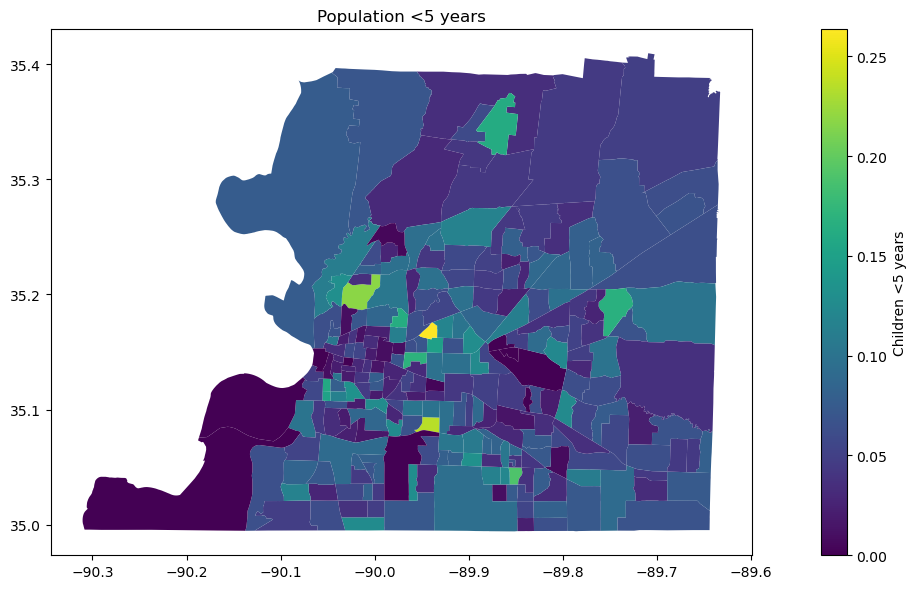

In [11]:
fig, ax = plt.subplots(1,1, figsize=(14,6))
gdf_u5.plot(
    column="pct_u5", 
    ax=ax, 
    legend=True, 
    legend_kwds={"label":"Children <5 years"}
)
ax.set_title("Population <5 years")
plt.tight_layout()
plt.show()

In [12]:
output_path = r"C:\Users\zmrplaza\OneDrive - The University of Memphis\Classes\Spring 2025\GIS Lab\Project\Children and Chronic\pct_u5\pct_u5.shp"

# Exportar a shapefile
gdf_u5.to_file(output_path)

print("Shapefile exported.")


Shapefile exported.


C:\Users\zmrplaza\AppData\Local\Temp\ipykernel_33832\3225851358.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_u5.to_file(output_path)
C:\Users\zmrplaza\AppData\Roaming\Python\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_population' to 'total_popu'
  ogr_write(


Shapefile de tracts con enfermedades crónicas normalizadas exportado.


C:\Users\zmrplaza\AppData\Local\Temp\ipykernel_33832\3978482259.py:45: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_joined.to_file(output_path_disease)
C:\Users\zmrplaza\AppData\Roaming\Python\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'tractfips_left' to 'tractfips_'
  ogr_write(
C:\Users\zmrplaza\AppData\Roaming\Python\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(
C:\Users\zmrplaza\AppData\Roaming\Python\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'tractfips_right' to 'tractfip_1'
  ogr_write(
C:\Users\zmrplaza\AppData\Roaming\Python\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'ghlth_crudeprev_norm' to 'ghlth_crud'
  ogr_write(


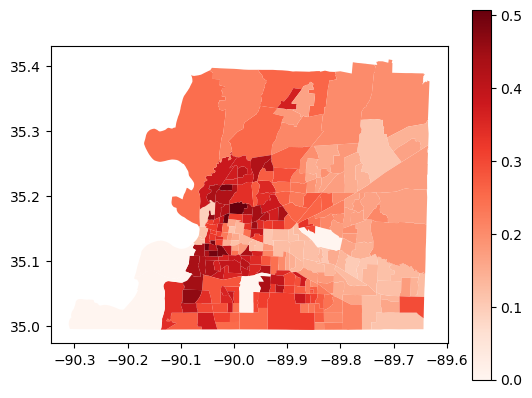

In [23]:
import urllib.parse

base = "https://data.cdc.gov/api/geospatial/yjkw-uj5s"
query = {
    "method": "export",
    "format": "GeoJSON",
    "where": "state_fips=47 AND county_fips=157"
}
url = base + "?" + urllib.parse.urlencode(query)
gdf_chronic = gpd.read_file(url)

# Filtrar por tracts de Shelby
gdf_chronic = gdf_chronic[gdf_chronic["tractfips"].str.startswith("47157")].copy()

# ===========================
# 2. Convertir la columna a numérico y normalizar
# ===========================
gdf_chronic["ghlth_crudeprev"] = pd.to_numeric(gdf_chronic["ghlth_crudeprev"], errors='coerce')
gdf_chronic["ghlth_crudeprev_norm"] = gdf_chronic["ghlth_crudeprev"] / 100

# ===========================
# 3. Hacer Spatial Join con los tracts
# ===========================
# Asegurar que ambos estén en la misma proyección
gdf_chronic = gdf_chronic.to_crs(tracts.crs)

# Join espacial: asignar valor del punto al tract
gdf_joined = gpd.sjoin(tracts, gdf_chronic[["tractfips", "ghlth_crudeprev_norm", "geometry"]], 
                       how="left", predicate='contains')

# ===========================
# 4. Rellenar tracts sin datos con 0
# ===========================
gdf_joined["ghlth_crudeprev_norm"] = gdf_joined["ghlth_crudeprev_norm"].fillna(0)

# ===========================
# 5. Graficar
# ===========================
gdf_joined.plot(column="ghlth_crudeprev_norm", cmap="Reds", legend=True)

# ===========================
# 6. Exportar a Shapefile
# ===========================
output_path_disease = r"C:\Users\zmrplaza\OneDrive - The University of Memphis\Classes\Spring 2025\GIS Lab\Project\Children and Chronic\chronic_normalized_tracts.shp"
gdf_joined.to_file(output_path_disease)

print("Shapefile de tracts con enfermedades crónicas normalizadas exportado.")